In [1]:
# import package
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Dropout, Activation,
                                     Flatten)
import tensorflow as tf

In [6]:
data_path = "train/"

x_data_list = []
y_data_list = []
for roots, dirs, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(os.path.join(roots.split("/")[-1], each))
            y_data_list.append(roots.split("/")[-1])

In [7]:
data_list = pd.DataFrame({})
data_list['img_path'] = x_data_list
data_list['label'] = y_data_list

In [8]:
data_list.head(3)

,img_path,label
0,buffalo\001.jpg,buffalo
1,buffalo\002.jpg,buffalo
2,buffalo\003.jpg,buffalo


In [9]:
from sklearn.model_selection import train_test_split

train_list, test_list = train_test_split(data_list,
                                         test_size=0.2,
                                         random_state=42,
                                         stratify=data_list['label'].values)

In [11]:
img_size = 224
num_class = len(data_list['label'].unique())
num_class
Sequential = 123

4

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [13]:
vgg_model = VGG16(weights='imagenet', include_top=False,
                  input_shape=(img_size, img_size, 3))

x = Flatten()(vgg_model.output)
# x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(num_class, activation='softmax')(x)


model = Model(inputs=vgg_model.inputs, outputs=outputs)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
vgg_model.trainable = False
vgg_model.trainable = True

trainable_layer = 3
for layer in vgg_model.layers[:-trainable_layer]:
    layer.trainable = False

for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000024BFCE10F40> False
<keras.layers.convolutional.Conv2D object at 0x0000024BFCE6D670> False
<keras.layers.convolutional.Conv2D object at 0x0000024BFCE6DC70> False
<keras.layers.pooling.MaxPooling2D object at 0x0000024B91B90FA0> False
<keras.layers.convolutional.Conv2D object at 0x0000024B91B90BE0> False
<keras.layers.convolutional.Conv2D object at 0x0000024B91B98DC0> False
<keras.layers.pooling.MaxPooling2D object at 0x0000024B91B9CA00> False
<keras.layers.convolutional.Conv2D object at 0x0000024B91BABF40> False
<keras.layers.convolutional.Conv2D object at 0x0000024BFCF0B490> False
<keras.layers.convolutional.Conv2D object at 0x0000024B91BB6C70> False
<keras.layers.pooling.MaxPooling2D object at 0x0000024B91BB9AF0> False
<keras.layers.convolutional.Conv2D object at 0x0000024B91BCB130> False
<keras.layers.convolutional.Conv2D object at 0x0000024B91BC0E50> False
<keras.layers.convolutional.Conv2D object at 0x0000024B91BB1EB0> False
<ker

In [16]:
learning_rate = 1e-4
optimizer = keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

c:\Users\Lucas\anaconda3\envs\tensorflow_new\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [17]:
batch_size = 32
num_steps = len(train_list) // batch_size + 1
num_epochs = 30

In [18]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
img_shape = (img_size, img_size)

train_generator = train_datagen.flow_from_dataframe(
                                                    dataframe=train_list,
                                                    directory=data_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

valid_generator = test_datagen.flow_from_dataframe(
                                                    dataframe=test_list,
                                                    directory=data_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 1203 validated image filenames belonging to 4 classes.
Found 301 validated image filenames belonging to 4 classes.


In [19]:
model_dir = 'model-logs/vgg16'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

logfiles = model_dir + '/{}-{}'.format('basic_model',
                                       model.__class__.__name__)
model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                        histogram_freq=1)

modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,
                                          verbose=1)


callbacks_list = [model_cbk, model_mckp, earlystop]

In [20]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=num_steps,
                              epochs=num_epochs,
                              validation_data=valid_generator,
                              callbacks=callbacks_list)

c:\Users\Lucas\anaconda3\envs\tensorflow_new\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
38/38 [==============================] - 25s 419ms/step - loss: 3.7494 - accuracy: 0.6916 - val_loss: 0.8833 - val_accuracy: 0.8472
Epoch 2/30
38/38 [==============================] - 8s 218ms/step - loss: 0.2621 - accuracy: 0.9343 - val_loss: 0.6620 - val_accuracy: 0.8771
Epoch 3/30
38/38 [==============================] - 8s 212ms/step - loss: 0.0897 - accuracy: 0.9784 - val_loss: 0.6498 - val_accuracy: 0.8738
Epoch 4/30
38/38 [==============================] - 8s 213ms/step - loss: 0.0418 - accuracy: 0.9834 - val_loss: 0.6491 - val_accuracy: 0.8870
Epoch 5/30
38/38 [==============================] - 8s 214ms/step - loss: 0.0159 - accuracy: 0.9933 - val_loss: 0.6460 - val_accuracy: 0.8904
Epoch 6/30
38/38 [==============================] - 8s 215ms/step - loss: 0.0232 - accuracy: 0.9950 - val_loss: 0.6912 - val_accuracy: 0.8937
Epoch 7/30
38/38 [==============================] - 8s 211ms/step - loss: 0.0123 - accuracy: 0.9958 - val_loss: 0.7150 - val_accuracy: 0.9136
Epoch

In [21]:
loss, acc = model.evaluate_generator(valid_generator, verbose=2)

c:\Users\Lucas\anaconda3\envs\tensorflow_new\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


10/10 - 2s - loss: 0.8269 - accuracy: 0.9136


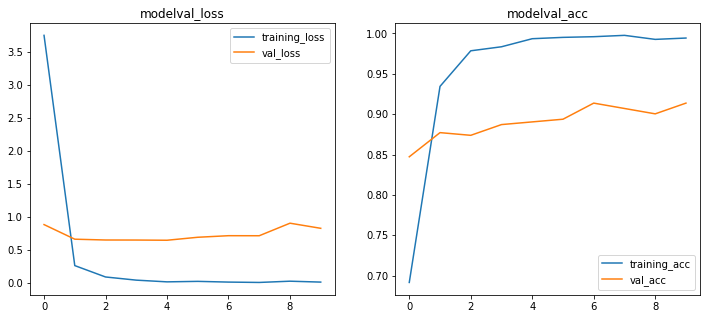

In [22]:
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title('model'+eachy)
plt.show()

In [24]:
new_model = keras.models.load_model('model-logs/vgg16/basic_model-best-model.h5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     